# Libraries

In [1]:
# Import libraries

from os import listdir
import string
import pandas as pd
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from attention import AttentionLayer
import warnings
import re, string, unicodedata
import nltk
import contractions
import pickle
import inflect
from bs4 import BeautifulSoup
import tensorflow as tf
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
lemmatizer = WordNetLemmatizer() 

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
#os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [4]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))
else:
   print("Please install GPU version of TF")

Please install GPU version of TF


# Loading data

In [5]:
# load doc into memory
def load_doc(filename):
	file = open(filename, encoding='utf-8')
	text = file.read()
	file.close()
	return text

# split a document into news story and highlights
def split_story(doc):
	# find first highlight
	index = doc.find('@highlight')
	# split into story and highlights
	story, highlights = doc[:index], doc[index:].split('@highlight')
	# strip extra white space around each highlight
	highlights = [h.strip() for h in highlights if len(h) > 0]
	return story, highlights

# load all stories in a directory
def load_stories(directory):
    stories = []
    highlights =[]
    for name in listdir(directory)[:10000]:
        filename = directory + '/' + name
		# load document
        doc = load_doc(filename)
		# split into story and highlights
        story, highlight = split_story(doc)
		# store
        stories.append(story)
        highlights.append(highlight)
    data = pd.DataFrame()
    data["story"] = stories
    data["highlight"] = highlights
    
    return  data

In [10]:
# load stories
directory = r"C:\Users\feder\Desktop\TMS_project\dati\cnn\stories"
data = load_stories(directory)


In [11]:
print('Loaded Stories %d' % len(data))

Loaded Stories 10000


# Cleaning and preprocessing


In [12]:
data.head()

,story,highlight
0,"It's official: U.S. President Barack Obama wants lawmakers to weigh in on whether to use military force in Syria.\n\nObama sent a letter to the heads of the House and Senate on Saturday night, hou...","[Syrian official: Obama climbed to the top of the tree, ""doesn't know how to get down"", Obama sends a letter to the heads of the House and Senate, Obama to seek congressional approval on military ..."
1,(CNN) -- Usain Bolt rounded off the world championships Sunday by claiming his third gold in Moscow as he anchored Jamaica to victory in the men's 4x100m relay.\n\nThe fastest man in the world cha...,"[Usain Bolt wins third gold of world championship, Anchors Jamaica to 4x100m relay victory, Eighth gold at the championships for Bolt, Jamaica double up in women's 4x100m relay]"
2,"Kansas City, Missouri (CNN) -- The General Services Administration, already under investigation for lavish spending, allowed an employee to telecommute from Hawaii even though he is based at the G...","[The employee in agency's Kansas City office is among hundreds of ""virtual"" workers, The employee's travel to and from the mainland U.S. last year cost more than $24,000, The telecommuting program..."
3,"Los Angeles (CNN) -- A medical doctor in Vancouver, British Columbia, said Thursday that California arson suspect Harry Burkhart suffered from severe mental illness in 2010, when she examined him ...","[NEW: A Canadian doctor says she was part of a team examining Harry Burkhart in 2010, NEW: Diagnosis: ""autism, severe anxiety, post-traumatic stress disorder and depression"", Burkhart is also susp..."
4,"(CNN) -- Police arrested another teen Thursday, the sixth suspect jailed in connection with the gang rape of a 15-year-old girl on a northern California high school campus.\n\nJose Carlos Montano,...","[Another arrest made in gang rape outside California school, Investigators say up to 20 people took part or stood and watched the assault, Four suspects appeared in court Thursday; three wore bull..."


In [13]:
data = data.explode("highlight")

## Normalization

In [14]:
stop_words = set(stopwords.words('english')) 

def remove_non_ascii(words):
    """Remove non-ASCII characters"""
    new_words = unicodedata.normalize('NFKD', words).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase"""
    new_words = words.lower()
    return new_words

def remove_punctuation(words):
    """Remove punctuation"""
    new_words = re.sub(r'\([^)]*\)', '', words)
    return new_words

def replace_numbers(words):
    """Replace all integer occurrences"""
    new_words = re.sub("[^a-zA-Z]", " ", words) 
    return new_words

def remove_stopwords(words):
    """Remove stop words"""
    new_words = [w for w in words.split() if not w in stop_words]
    long_words=[]
    for i in new_words:
        if len(i)>=1:                  
            long_words.append(i)   

    return (" ".join(long_words)).strip()


def replace_contractions(words):
    """Replace contractions in string of text"""
    return contractions.fix(words)

def normalize(words):
    words = remove_non_ascii(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = replace_contractions(words)
    words = remove_stopwords(words)

    return words

In [15]:
#Call the above function

cleaned_story = []
for t in data['story']:
    cleaned_story.append(normalize(t))

cleaned_highlight = []
for t in data['highlight']:
    cleaned_highlight.append(normalize(t))

data['normalized_text']=cleaned_story
data['normalized_highlight']=cleaned_highlight
data['normalized_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Lemmatization

In [16]:
def lemmatize(words):
    words = lemmatizer.lemmatize(words)
    return words

In [17]:
#Call the above function

lemmatized_story = []
for t in data['normalized_text']:
    lemmatized_story.append(lemmatize(t))
    
lemmatized_highlight = []
for t in data['normalized_highlight']:
    lemmatized_highlight.append(lemmatize(t))

data['cleaned_text']=lemmatized_story
data['cleaned_highlight']=lemmatized_highlight
data['cleaned_highlight'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

## Add start and end tokens for the summarizer

In [18]:
data['cleaned_highlight'] = data['cleaned_highlight'].apply(lambda x : 'starttoken '+ x + ' endtoken')


## Visualize results

In [19]:
data = data[["cleaned_text", "cleaned_highlight"]]
data

,cleaned_text,cleaned_highlight
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken syrian official obama climbed top tree know get endtoken
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken obama sends letter heads house senate endtoken
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken obama seek congressional approval military action syria endtoken
0,official president barack obama wants lawmakers weigh whether use military force syria obama sent letter heads house senate saturday night hours announcing believes military action syrian targets ...,starttoken aim determine whether cw used says n spokesman endtoken
1,usain bolt rounded world championships sunday claiming third gold moscow anchored jamaica victory men x relay fastest man world charged clear united states rival justin gatlin jamaican quartet nes...,starttoken usain bolt wins third gold world championship endtoken
...,...,...
9998,rapper fat joe others entourage briefly detained questioned early monday woman reported alleged sexual assault madison wisconsin police said year old madison woman called police complaint inapprop...,starttoken rapper lawyer calls woman groupie pretender endtoken
9999,johannesburg south africa former south african president nelson mandela led mourning great granddaughter chapel johannesburg south africa thursday office announced zenani mandela buried private ce...,starttoken zenani mandela killed car wreck last week endtoken
9999,johannesburg south africa former south african president nelson mandela led mourning great granddaughter chapel johannesburg south africa thursday office announced zenani mandela buried private ce...,starttoken whispered ear love mother says memorial endtoken
9999,johannesburg south africa former south african president nelson mandela led mourning great granddaughter chapel johannesburg south africa thursday office announced zenani mandela buried private ce...,starttoken zenani thrilled meeting soccer star cristiano ronaldo two days died endtoken


## Dataset splitting

In [20]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_highlight'],test_size=0.1,random_state=0,shuffle=True) 

## Tokenization

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))

In [22]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 20.37335164184758
Total Coverage of rare words: 0.39457576608869416


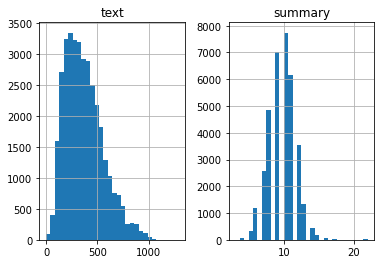

In [23]:

import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_highlight']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

In [24]:
cnt=0
for i in data['cleaned_highlight']:
    if(len(i.split())<=14):
        cnt=cnt+1
print(cnt/len(data['cleaned_highlight']))

0.9925093632958801


In [25]:
max_text_len=300
max_summary_len=12

In [26]:
#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)


In [27]:
#padding zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc = x_tokenizer.num_words + 1

In [28]:
x_voc

49234

In [29]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

In [30]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 75.13038910359836
Total Coverage of rare words: 12.006825652323979


In [31]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1


In [32]:
y_voc

6629

In [33]:
y_tokenizer.word_counts['starttoken'],len(y_tr)


(31959, 31959)

In [34]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [35]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

# Saving the data

In [59]:
np.save("final_data/x_tr.npy", x_tr)
np.save("final_data/y_tr.npy", y_tr)
np.save("final_data/x_val.npy", x_val)
np.save("final_data/y_val.npy", y_val)


In [60]:
import pickle

# saving
with open('y_tokenizer.pickle', 'wb') as handle:
    pickle.dump(y_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('x_tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('vars.pkl', 'wb') as f:  
    pickle.dump([x_voc, y_voc], f)

# Load data

In [5]:
x_tr = np.load("final_data/x_tr.npy")
y_tr = np.load("final_data/y_tr.npy")
x_val = np.load("final_data/x_val.npy")
y_val = np.load("final_data/y_val.npy")

In [6]:
def open_test_data_y():
    return open('y_tokenizer.pickle', 'rb')

with open_test_data_y() as f:
    y_tokenizer = pickle.load(f) 

def open_test_data_x():
    return open('x_tokenizer.pickle', 'rb')

with open_test_data_x() as f:
    x_tokenizer = pickle.load(f) 

def open_vars():
    return open('vars.pkl', 'rb')

with open_vars() as f:  # Python 3: open(..., 'rb')
    x_voc, y_voc = pickle.load(f)

In [7]:
max_text_len=300
max_summary_len=12

# Modeling

In [13]:
from tensorflow.keras import backend as K 
K.clear_session()

latent_dim = 300
embedding_dim=100

# Encoder

encoder_inputs = Input(shape=(max_text_len,))
#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)
#encoder lstm 1
encoder_lstm1 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4))
print(encoder_lstm1(enc_emb))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm1(enc_emb)
encoder_states = [forward_h, forward_c, backward_h, backward_c]


# Decoder

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(max_text_len,))
#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2))
decoder_outputs,_, _,_,_ = decoder_lstm(dec_emb,initial_state=[forward_h, forward_c, backward_h, backward_c])

# Attention layer

attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# Concat attention input and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_concat_input)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

[<KerasTensor: shape=(None, 300, 600) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'bidirectional')>, <KerasTensor: shape=(None, 300) dtype=float32 (created by layer 'bidirectional')>]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 300)]        0                                            
_____________________________________________________________________

In [14]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')


In [15]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=1, verbose = 1,
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

ValueError: in user code:

    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\keras\engine\training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\keras\engine\training.py:788 run_step  **
        outputs = model.train_step(data)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\keras\engine\training.py:754 train_step
        y_pred = self(x, training=True)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    C:\Users\feder\.conda\envs\nlp\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:271 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 1 is incompatible with layer model: expected shape=(None, 300), found shape=(None, 11)


In [43]:
model.save_weights("weights.h5")

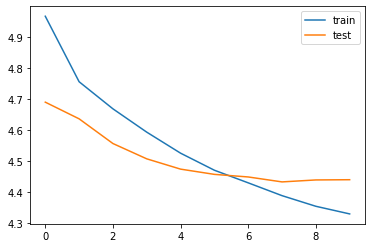

In [44]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()

# Inference

In [9]:
model.load_weights("weights.h5")

In [10]:
reverse_target_word_index=y_tokenizer.index_word
reverse_source_word_index=x_tokenizer.index_word
target_word_index=y_tokenizer.word_index

In [11]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs) 
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [12]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['starttoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [13]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['starttoken']) and i!=target_word_index['endtoken']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [14]:
for i in range(0,30):
    print("Review:",seq2text(x_tr[i]))
    print("Original summary:",seq2summary(y_tr[i]))
    print("Predicted summary:",decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print("\n")

Review: man hated britain story accompanied website picture later removed miliband senior burial plot captioned grave socialist mail certainly commercially successful one papers still selling good numbers visited newspaper website world many people public life along campaigners protested outside mail offices west london view mail group worst standards public life something argued many years one two people though far fewer supported attacks feel gone top describing editor chief paul dacre biggest poison british public life bully hypocrite coward even defend actions public things even ludicrous attempts get minions tv justifying attack miliband dead father claimed labour leader wants state control press politicians decide goes newspapers opposite miliband said leveson inquiry editors furious dacre tactical fearing one possible consequence mail vicious attack miliband may bring tougher regulation britain press fact think politicians sufficient commitment freedom press allow vicious row si

In [15]:
original_text = []
original_summary = []
created_summary = []

for i in range(0,30):
    original_text.append(seq2text(x_tr[i]))
    original_summary.append(seq2summary(y_tr[i]))
    created_summary.append(decode_sequence(x_tr[i].reshape(1,max_text_len)))

In [16]:
results = pd.DataFrame()
results["Original_text"] = original_text
results["Original_summary"] = original_summary
results["Created_summary"] = created_summary

In [17]:
results.to_csv("results_predictions.csv")

In [18]:
results=pd.read_csv("results_predictions.csv")

In [19]:
reference_sentences = results["Original_summary"].to_list()
summary_sentences = results["Created_summary"].to_list()

In [21]:
from rouge import rouge_n_sentence_level
from rouge import rouge_l_sentence_level
from rouge import rouge_n_summary_level
from rouge import rouge_l_summary_level
from rouge import rouge_w_sentence_level
from rouge import rouge_w_summary_level

list_rouge = []
list_recall = []
list_precision = []

for i in range(0, len(reference_sentences)):
    reference_sentence = reference_sentences[i].split()
    summary_sentence = summary_sentences[i].split()
    
    # Calculate ROUGE-2.
    recall, precision, rouge = rouge_n_sentence_level(summary_sentence, reference_sentence, 2)
    #print('ROUGE-2-R', recall)
    #print('ROUGE-2-P', precision)
    #print('ROUGE-2-F', rouge)

    list_rouge.append(rouge)
    list_recall.append(recall)
    list_precision.append(precision)

import statistics


mean_rouge = statistics.mean(list_rouge)  
print(mean_rouge)

0.011794871794871795


In [51]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''